In [1]:
import numpy as np 
import pandas as pd 

import time

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score 

import matplotlib.pyplot as plt
import seaborn as sns

import random

import os

import tensorflow as tf
from tensorflow.keras.models import load_model,Sequential
from tensorflow.keras.layers import Dense , Flatten, Conv2D, MaxPooling2D, Dropout, Input , BatchNormalization ,GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import to_categorical , plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,array_to_img,img_to_array

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("noodulz/pokemon-dataset-1000")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/pokemon-dataset-1000


In [3]:
path = str(path)
dataset_path = path + '/pokemon-dataset-1000/dataset'
train_path = path + '/pokemon-dataset-1000/train'
test_path = path + '/pokemon-dataset-1000/test'
val_path = path + '/pokemon-dataset-1000/val'

In [4]:
label = []
path = []
main_dir = dataset_path
for i in os.listdir(main_dir):
    for img in os.listdir(f"{main_dir}/{i}"):
        label.append(i)
        path.append(f"{main_dir}/{i}/{img}")

In [5]:
df = pd.DataFrame(columns=['label', 'path'])
df['label'] = label
df['path'] = path

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26539 entries, 0 to 26538
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   26539 non-null  object
 1   path    26539 non-null  object
dtypes: object(2)
memory usage: 414.8+ KB


In [7]:
df.nunique()

label     1000
path     26539
dtype: int64

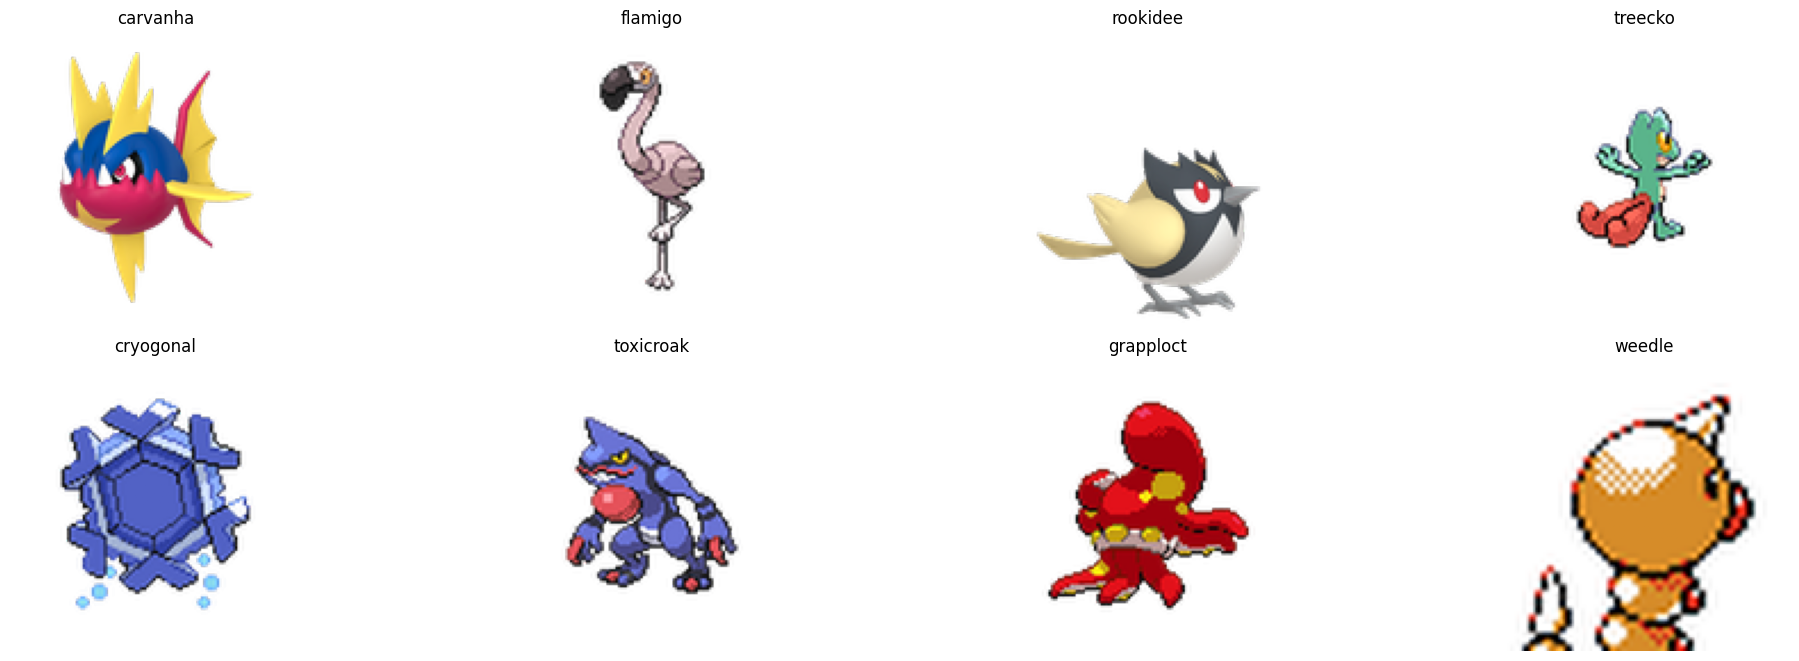

In [8]:
# displaying random pokemon images
rand_labels = random.sample(df['label'].unique().tolist(), 8)

plt.figure(figsize=(20, 10))
for idx, label in enumerate(rand_labels):
    plt.subplot(3, 4, idx + 1)
    img_path = df[df['label'] == label].iloc[0, 1]
    plt.imshow(plt.imread(img_path))
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
# checking for image dimensions of random pokemon to confirm uniformity
from PIL import Image

rand_imgs = random.sample(list(df['path']), 1000)

img_shapes = []

for img_path in rand_imgs:
    img = Image.open(img_path)
    img_shapes.append(img.size)

widths, heights = zip(*img_shapes)

avg_shape = np.mean(widths), np.mean(heights)

print(f"Average image shape: {avg_shape}")

Average image shape: (128.0, 128.0)


In [10]:
df['label']

0        whimsicott
1        whimsicott
2        whimsicott
3        whimsicott
4        whimsicott
            ...    
26534        nickit
26535        nickit
26536        nickit
26537        nickit
26538        nickit
Name: label, Length: 26539, dtype: object

In [11]:
# label encoding

labels = df['label'].astype('category').cat.codes 
df['label_encoded'] = labels

img_size = (128, 128)

images = []
for i in df['path']:
    img = load_img(i, target_size=img_size)
    img = img_to_array(img)
    img = img / 255.0 # Normalizing the pixel values (from 0 to 225 to 0 to 1)
    images.append(img)

X = np.array(images)
y = df['label_encoded']

# .astype('category'): This converts the data type of the 'label' column to the Pandas category data type. 
# This is crucial because it tells Pandas to treat the values in this column as distinct categories, not just strings or numbers.  
# This step is important for the next operation.

# .cat.codes: This is the key part.  The .cat accessor is used specifically for columns of the category data type.  
# The .codes attribute returns a NumPy array of integers.  Each unique category in the original column is assigned a unique integer code.  
# These codes start from 0 and go up to the number of unique categories minus 1.

# labels = ...: Finally, the resulting NumPy array of integer codes is assigned to the variable labels.

In [12]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.15, random_state=42, stratify = y)

In [13]:
print(f"X_train shape: {xtrain.shape}\nX_test shape: {xtest.shape}\nY_train shape: {ytrain.shape}\nY_test shape: {ytest.shape}")

X_train shape: (22558, 128, 128, 3)
X_test shape: (3981, 128, 128, 3)
Y_train shape: (22558,)
Y_test shape: (3981,)


In [14]:
ytest.nunique()

1000

In [15]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# The selected code computes class weights for an imbalanced dataset and converts them into a dictionary
# using the dict(enumerate(class_weights)) function. The class weights are calculated using the compute_class_weight function

# ---------------------------------------------------------

# compute_class_weight:
# ----------------------
# Calculates weights for each class to handle class imbalance.
# class_weight='balanced' ensures weights are inversely proportional to class frequencies.
# classes=np.unique(y_train) provides unique class labels.
# y=y_train is the array of class labels.

# ---------------------------------------------------------

# dict(enumerate(class_weights)):
# ----------------------
# Converts the list of class weights into a dictionary where keys are class indices and values are the weights.

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(ytrain),
    y=ytrain
)
class_weights_dict = dict(enumerate(class_weights))

In [16]:
print(ytrain.shape,"\n",ytest.shape)

(22558,) 
 (3981,)


# **EfficientNet**

In [17]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

Effnetmodel = Sequential([
    base_model,  
    GlobalAveragePooling2D(), 
    BatchNormalization(),
    Dense(256, activation='relu', name="Layer1"),
    BatchNormalization(),
    Dropout(0.5), 
    Dense(128, activation='relu', name="Layer2"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1000, activation='softmax', name="output_layer")
])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
Effnetmodel.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
def image_generator(X, y, batch_size, class_weights):
    while True:
        
        for i in range(0, len(X), batch_size):
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]
            
            
            sample_weights = np.array([class_weights.get(label, 1.0) for label in y_batch])

            yield X_batch, y_batch, sample_weights

In [20]:
start_time = time.time()

history = Effnetmodel.fit(
    image_generator(xtrain, ytrain, batch_size=128, class_weights=class_weights_dict),
    steps_per_epoch=len(xtrain) // 128,  
    epochs=15,
    validation_data=image_generator(xtest, ytest, batch_size=128, class_weights=class_weights_dict),
    validation_steps=len(xtest) // 128   
)

end_time = time.time()
training_time = end_time - start_time

Epoch 1/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 102s 182ms/step - accuracy: 0.0043 - loss: 6.9176 - val_accuracy: 0.0015 - val_loss: 6.9798
Epoch 2/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 67s 174ms/step - accuracy: 0.0660 - loss: 5.8929 - val_accuracy: 0.0034 - val_loss: 7.0830
Epoch 3/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 26s 149ms/step - accuracy: 0.2238 - loss: 4.4813 - val_accuracy: 0.0392 - val_loss: 6.0476
Epoch 4/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 26s 149ms/step - accuracy: 0.4208 - loss: 3.0800 - val_accuracy: 0.3159 - val_loss: 3.2023
Epoch 5/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 26s 149ms/step - accuracy: 0.5998 - loss: 2.0324 - val_accuracy: 0.7784 - val_loss: 1.1687
Epoch 6/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 26s 149ms/step - accuracy: 0.7207 - loss: 1.3403 - val_accuracy: 0.8746 - val_loss: 0.6338
Epoch 7/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 26s 149ms/step - accuracy: 0.8184 - loss: 0.8750 - val_accuracy: 0.9118 - val_loss: 0.4197
Epoch 8/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 26s 148ms/step - accuracy: 0.8770 - loss: 

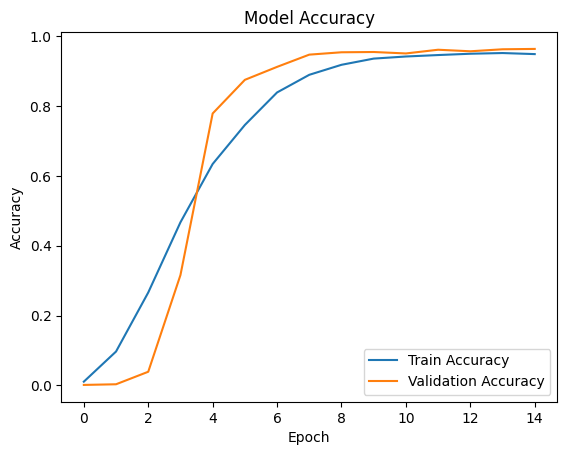

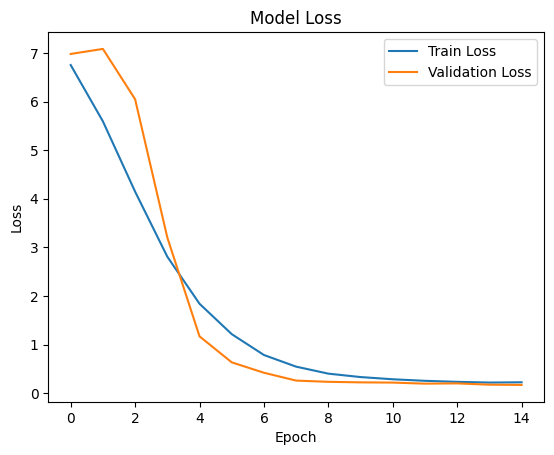

In [21]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
start_time = time.time()

y_pred = Effnetmodel.predict(xtest)

end_time = time.time()
inference_time = end_time - start_time


y_pred = y_pred.argmax(axis=1) 
f1_weighted = f1_score(ytest, y_pred, average='weighted')
print(f"Weighted Average F1 Score: {f1_weighted:.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step
Weighted Average F1 Score: 0.9615


In [23]:
Effnetmodel.save_weights("EfficientNet.weights.h5")

In [24]:
print("Training time:", training_time,"\nInference Time:", inference_time)

Training time: 509.1596326828003 
Inference Time: 14.151033639907837


# **Xception Model** # 

In [25]:
# Load the Xception model without the top (fully connected) layers
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model (optional, for transfer learning)
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x) # Fully connected layer
predictions = Dense(1000, activation='softmax')(x)  # Output layer

# Create the final model
Xceptionmodel = Model(inputs=base_model.input, outputs=predictions)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
Xceptionmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
start_time = time.time()

history = Xceptionmodel.fit(
    image_generator(xtrain, ytrain, batch_size=128, class_weights=class_weights_dict),
    steps_per_epoch=len(xtrain) // 128,  
    epochs=15,
    validation_data=image_generator(xtest, ytest, batch_size=128, class_weights=class_weights_dict),
    validation_steps=len(xtest) // 128   
)

end_time = time.time()
training_time = end_time - start_time

Epoch 1/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 31s 121ms/step - accuracy: 0.0615 - loss: 6.4119 - val_accuracy: 0.3730 - val_loss: 3.3452
Epoch 2/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 24s 118ms/step - accuracy: 0.4707 - loss: 2.4323 - val_accuracy: 0.5614 - val_loss: 2.0232
Epoch 3/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.6988 - loss: 1.2310 - val_accuracy: 0.6686 - val_loss: 1.5325
Epoch 4/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 19s 105ms/step - accuracy: 0.8062 - loss: 0.7482 - val_accuracy: 0.7262 - val_loss: 1.3066
Epoch 5/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step - accuracy: 0.8738 - loss: 0.4971 - val_accuracy: 0.7532 - val_loss: 1.2123
Epoch 6/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 19s 105ms/step - accuracy: 0.9168 - loss: 0.3318 - val_accuracy: 0.7880 - val_loss: 1.0923
Epoch 7/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step - accuracy: 0.9433 - loss: 0.2345 - val_accuracy: 0.7942 - val_loss: 1.0360
Epoch 8/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.9628 - loss: 0

In [28]:
Xceptionmodel.save_weights("Xception.weights.h5")

In [29]:
start_time = time.time()

y_pred = Xceptionmodel.predict(xtest)

end_time = time.time()
inference_time = end_time - start_time


y_pred = y_pred.argmax(axis=1) 
f1_weighted = f1_score(ytest, y_pred, average='weighted')
print(f"Weighted Average F1 Score: {f1_weighted:.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step
Weighted Average F1 Score: 0.8343


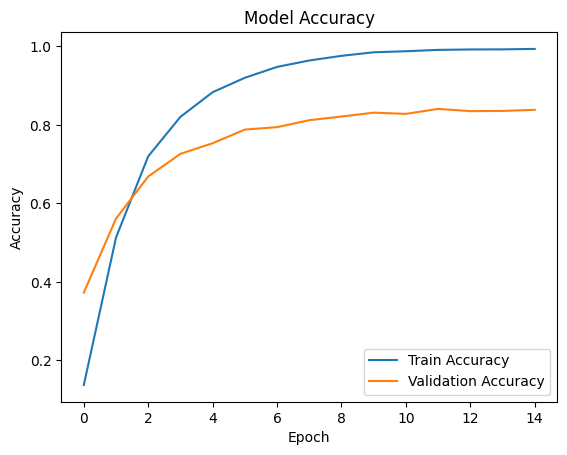

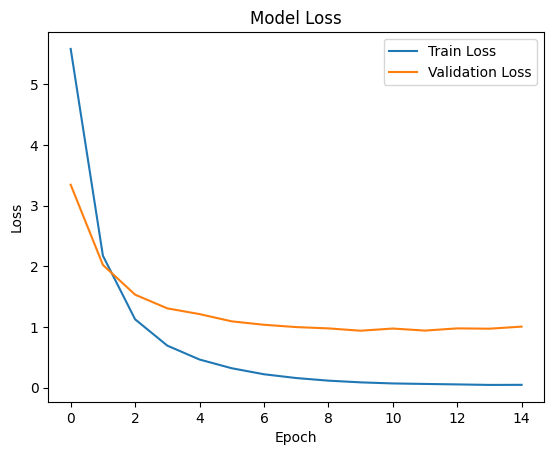

In [30]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
print("Training time:", training_time,"\nInference Time:", inference_time)

Training time: 296.43000292778015 
Inference Time: 9.928315877914429


# **Inceptionv3** # 

In [32]:
from tensorflow.keras.applications import InceptionV3
# Load InceptionV3 with pre-trained weights, excluding the top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model (optional, for transfer learning)
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.2)(x) # Dropout to reduce overfitting
predictions = Dense(1000, activation='softmax')(x)  # Output layer

# Create the final model
InceptionV3model = Model(inputs=base_model.input, outputs=predictions)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [33]:
InceptionV3model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [34]:
start_time = time.time()

history = InceptionV3model.fit(
    image_generator(xtrain, ytrain, batch_size=128, class_weights=class_weights_dict),
    steps_per_epoch=len(xtrain) // 128,  
    epochs=15,
    validation_data=image_generator(xtest, ytest, batch_size=128, class_weights=class_weights_dict),
    validation_steps=len(xtest) // 128   
)

end_time = time.time()
training_time = end_time - start_time

Epoch 1/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.0180 - loss: 6.8721 - val_accuracy: 0.1641 - val_loss: 4.9131
Epoch 2/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.1875 - loss: 4.1706 - val_accuracy: 0.3356 - val_loss: 3.2826
Epoch 3/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.3528 - loss: 2.7983 - val_accuracy: 0.4038 - val_loss: 2.7949
Epoch 4/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.4534 - loss: 2.1531 - val_accuracy: 0.4872 - val_loss: 2.3716
Epoch 5/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.5372 - loss: 1.7343 - val_accuracy: 0.5515 - val_loss: 2.0734
Epoch 6/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.6002 - loss: 1.4430 - val_accuracy: 0.5751 - val_loss: 1.9049
Epoch 7/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.6451 - loss: 1.2283 - val_accuracy: 0.6120 - val_loss: 1.7899
Epoch 8/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.6835 - loss: 1.0844 - val_ac

In [35]:
InceptionV3model.save_weights("Inceptionv3.weights.h5")

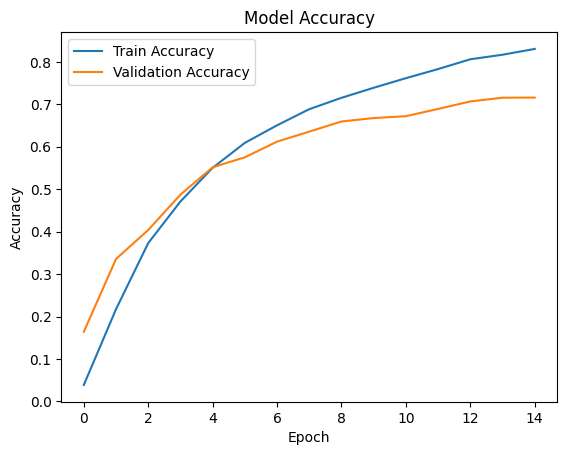

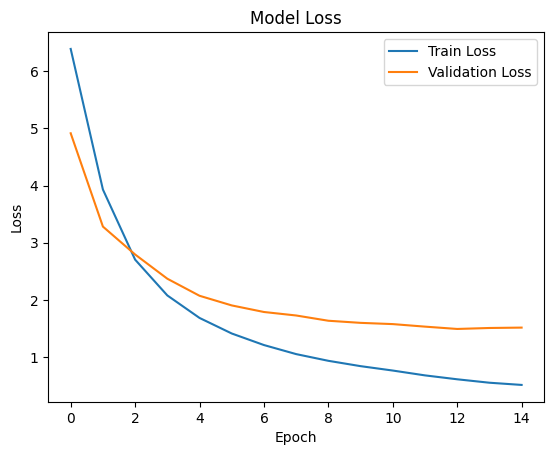

In [36]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
start_time = time.time()

y_pred = InceptionV3model.predict(xtest)

end_time = time.time()
inference_time = end_time - start_time


y_pred = y_pred.argmax(axis=1) 
f1_weighted = f1_score(ytest, y_pred, average='weighted')
print(f"Weighted Average F1 Score: {f1_weighted:.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step
Weighted Average F1 Score: 0.7038


In [38]:
print("Training time:", training_time,"\nInference Time:", inference_time)

Training time: 168.94353795051575 
Inference Time: 16.058542251586914


# Custom Cnn

In [39]:
# custom cnn

CustomModel = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(1024, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(2048, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(1000, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
CustomModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [41]:
start_time = time.time()

history = CustomModel.fit(
    image_generator(xtrain, ytrain, batch_size=128, class_weights=class_weights_dict),
    steps_per_epoch=len(xtrain) // 128,  
    epochs=15,
    validation_data=image_generator(xtest, ytest, batch_size=128, class_weights=class_weights_dict),
    validation_steps=len(xtest) // 128   
)

end_time = time.time()
training_time = end_time - start_time

Epoch 1/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accuracy: 2.7892e-04 - loss: 6.8965 - val_accuracy: 0.0015 - val_loss: 6.9119
Epoch 2/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.0013 - loss: 6.8862 - val_accuracy: 0.0016 - val_loss: 6.9105
Epoch 3/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.0012 - loss: 6.9066 - val_accuracy: 0.0013 - val_loss: 6.8740
Epoch 4/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 8.6125e-04 - loss: 6.8941 - val_accuracy: 7.7861e-04 - val_loss: 6.9135
Epoch 5/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.0011 - loss: 6.8937 - val_accuracy: 7.7861e-04 - val_loss: 6.9340
Epoch 6/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 9.8516e-04 - loss: 6.9054 - val_accuracy: 5.1908e-04 - val_loss: 6.9200
Epoch 7/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 9.8735e-04 - loss: 6.9195 - val_accuracy: 7.7861e-04 - val_loss: 6.8909
Epoch 8/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - ac

In [42]:
CustomModel.save_weights("Custom.weights.h5")

In [43]:
start_time = time.time()

y_pred = CustomModel.predict(xtest)

end_time = time.time()
inference_time = end_time - start_time


y_pred = y_pred.argmax(axis=1) 
f1_weighted = f1_score(ytest, y_pred, average='weighted')
print(f"Weighted Average F1 Score: {f1_weighted:.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Weighted Average F1 Score: 0.0000


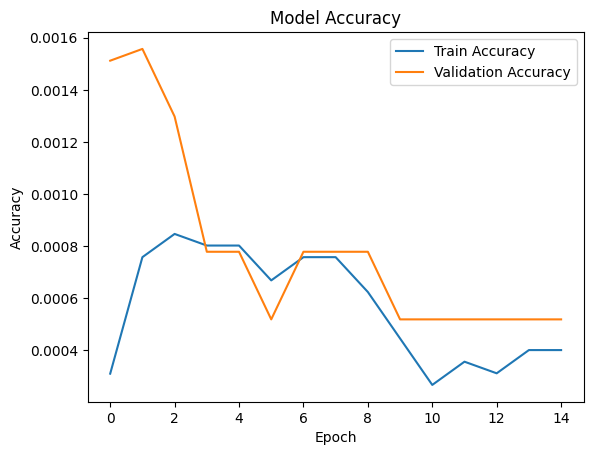

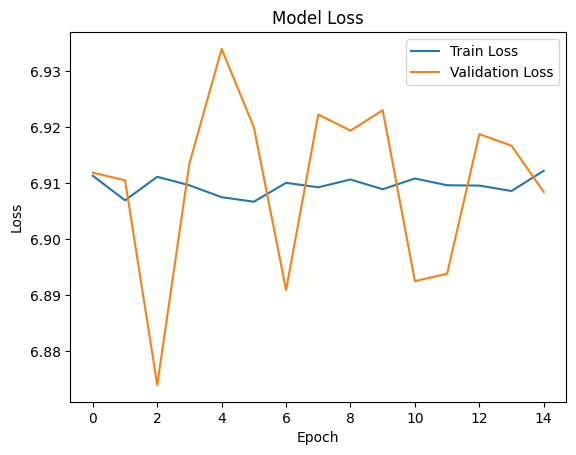

In [44]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [45]:
print("Training time:", training_time,"\nInference Time:", inference_time)

Training time: 187.30530095100403 
Inference Time: 4.587400197982788


# MobileNet

In [46]:
from tensorflow.keras.applications import MobileNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model (optional, for transfer learning)
base_model.trainable = False

# Add custom layers on top of the base model

x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.2)(x) # Dropout to reduce overfitting
predictions = Dense(1000, activation='softmax')(x)  # Output layer

# Create the final model
MobileNetmodel = Model(inputs=base_model.input, outputs=predictions)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [47]:
MobileNetmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [48]:
start_time = time.time()

history = MobileNetmodel.fit(
    image_generator(xtrain, ytrain, batch_size=128, class_weights=class_weights_dict),
    steps_per_epoch=len(xtrain) // 128,  
    epochs=15,
    validation_data=image_generator(xtest, ytest, batch_size=128, class_weights=class_weights_dict),
    validation_steps=len(xtest) // 128   
)

end_time = time.time()
training_time = end_time - start_time

Epoch 1/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.1166 - loss: 6.0676 - val_accuracy: 0.7072 - val_loss: 1.4533
Epoch 2/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.7677 - loss: 0.9678 - val_accuracy: 0.8438 - val_loss: 0.6869
Epoch 3/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9017 - loss: 0.3913 - val_accuracy: 0.8806 - val_loss: 0.5304
Epoch 4/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9479 - loss: 0.2192 - val_accuracy: 0.9066 - val_loss: 0.4480
Epoch 5/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9708 - loss: 0.1317 - val_accuracy: 0.9154 - val_loss: 0.4151
Epoch 6/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9824 - loss: 0.0782 - val_accuracy: 0.9234 - val_loss: 0.3928
Epoch 7/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9888 - loss: 0.0630 - val_accuracy: 0.9323 - val_loss: 0.3478
Epoch 8/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9947 - loss: 0.0379 - val_ac

In [49]:
MobileNetmodel.save_weights("MobileNet.weights.h5")

In [50]:
start_time = time.time()

y_pred = MobileNetmodel.predict(xtest)

end_time = time.time()
inference_time = end_time - start_time


y_pred = y_pred.argmax(axis=1) 
f1_weighted = f1_score(ytest, y_pred, average='weighted')
print(f"Weighted Average F1 Score: {f1_weighted:.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step
Weighted Average F1 Score: 0.9337


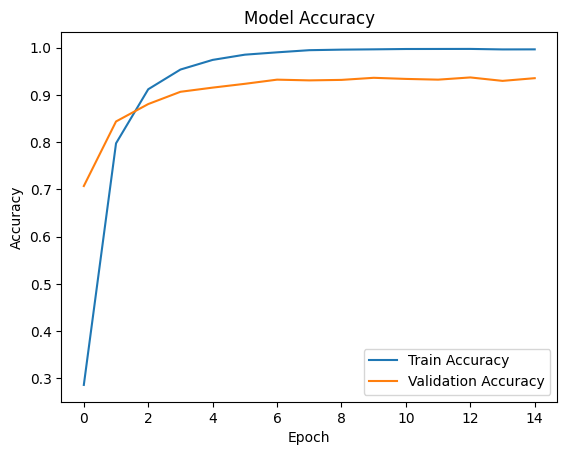

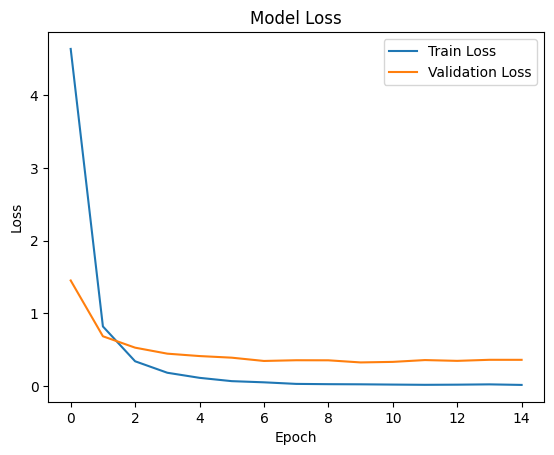

In [51]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [52]:
print("Training time:", training_time,"\nInference Time:", inference_time)

Training time: 95.23893117904663 
Inference Time: 5.981135845184326


# Nasnet (Mobile)

In [53]:
from tensorflow.keras.applications import NASNetMobile
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model (optional, for transfer learning)
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.2)(x) # Dropout to reduce overfitting
predictions = Dense(1000, activation='softmax')(x)  # Output layer

# Create the final model
NASNetMobilemodel = Model(inputs=base_model.input, outputs=predictions)

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [54]:
NASNetMobilemodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [56]:
history = NASNetMobilemodel.fit(
    image_generator(xtrain, ytrain, batch_size=128, class_weights=class_weights_dict),
    steps_per_epoch=len(xtrain) // 128,  
    epochs=15,
    validation_data=image_generator(xtest, ytest, batch_size=128, class_weights=class_weights_dict),
    validation_steps=len(xtest) // 128   
)

Epoch 1/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 0.4604 - loss: 2.7121 - val_accuracy: 0.5081 - val_loss: 2.4258
Epoch 2/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - accuracy: 0.6589 - loss: 1.4835 - val_accuracy: 0.5837 - val_loss: 1.9116
Epoch 3/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.7662 - loss: 0.9751 - val_accuracy: 0.6540 - val_loss: 1.6396
Epoch 4/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.8320 - loss: 0.6813 - val_accuracy: 0.6896 - val_loss: 1.4708
Epoch 5/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.8799 - loss: 0.5002 - val_accuracy: 0.7111 - val_loss: 1.3881
Epoch 6/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.9080 - loss: 0.3794 - val_accuracy: 0.7277 - val_loss: 1.3187
Epoch 7/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.9265 - loss: 0.2947 - val_accuracy: 0.7425 - val_loss: 1.2977
Epoch 8/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.9398 - loss: 0.2502 

In [57]:
NASNetMobilemodel.save_weights("NASNetMobile.weights.h5")

In [58]:
start_time = time.time()

y_pred = NASNetMobilemodel.predict(xtest)

end_time = time.time()
inference_time = end_time - start_time


y_pred = y_pred.argmax(axis=1) 
f1_weighted = f1_score(ytest, y_pred, average='weighted')
print(f"Weighted Average F1 Score: {f1_weighted:.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 101ms/step
Weighted Average F1 Score: 0.7877


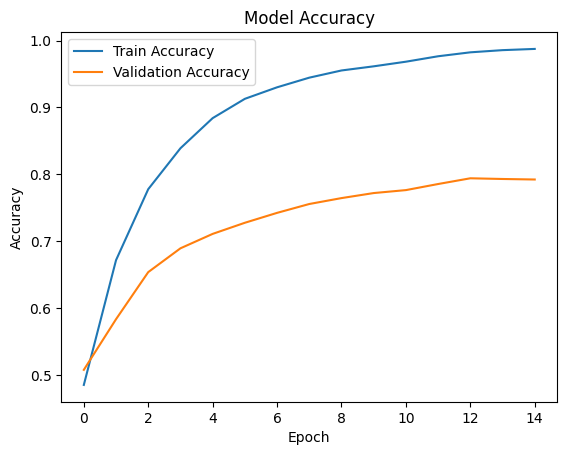

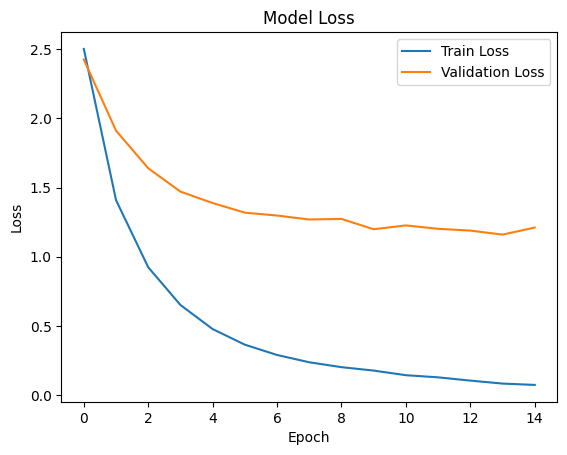

In [59]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [60]:
print("Training time:", training_time,"\nInference Time:", inference_time)

Training time: 95.23893117904663 
Inference Time: 26.888360500335693


# Resnet 50

In [61]:
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model (optional, for transfer learning)
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.2)(x) # Dropout to reduce overfitting
predictions = Dense(1000, activation='softmax')(x)  # Output

# Create the final model
ResNet50model = Model(inputs=base_model.input, outputs=predictions)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [62]:
ResNet50model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [63]:
history = ResNet50model.fit(
    image_generator(xtrain, ytrain, batch_size=128, class_weights=class_weights_dict),
    steps_per_epoch=len(xtrain) // 128,  
    epochs=15,
    validation_data=image_generator(xtest, ytest, batch_size=128, class_weights=class_weights_dict),
    validation_steps=len(xtest) // 128   
)

Epoch 1/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.0017 - loss: 6.9550 - val_accuracy: 0.0030 - val_loss: 6.8287
Epoch 2/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - accuracy: 0.0017 - loss: 6.7805 - val_accuracy: 0.0036 - val_loss: 6.7405
Epoch 3/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.0029 - loss: 6.7056 - val_accuracy: 0.0055 - val_loss: 6.6097
Epoch 4/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.0055 - loss: 6.5974 - val_accuracy: 0.0093 - val_loss: 6.5703
Epoch 5/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.0078 - loss: 6.5101 - val_accuracy: 0.0112 - val_loss: 6.5266
Epoch 6/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.0093 - loss: 6.4455 - val_accuracy: 0.0140 - val_loss: 6.4527
Epoch 7/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.0110 - loss: 6.3855 - val_accuracy: 0.0208 - val_loss: 6.3155
Epoch 8/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.0162 - loss: 6.2758 - 

In [64]:
ResNet50model.save_weights("ResNet50.weights.h5")

In [65]:
start_time = time.time()

y_pred = ResNet50model.predict(xtest)

end_time = time.time()
inference_time = end_time - start_time


y_pred = y_pred.argmax(axis=1) 
f1_weighted = f1_score(ytest, y_pred, average='weighted')
print(f"Weighted Average F1 Score: {f1_weighted:.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step
Weighted Average F1 Score: 0.0354


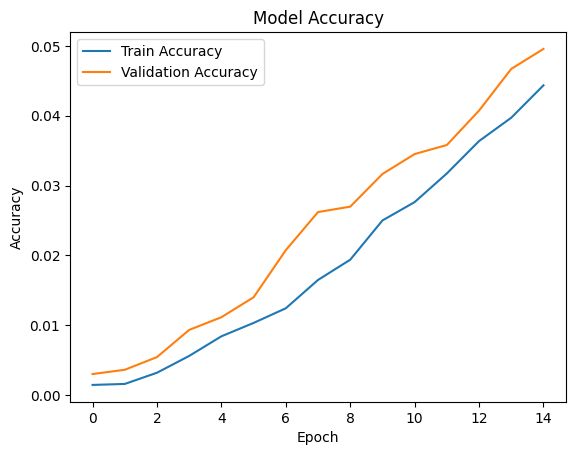

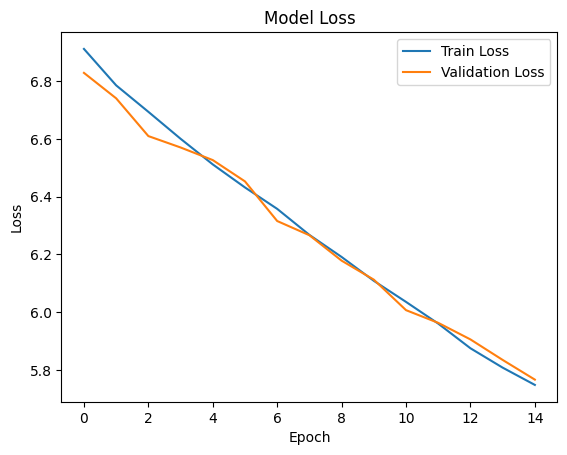

In [66]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [67]:
print("Training time:", training_time,"\nInference Time:", inference_time)

Training time: 95.23893117904663 
Inference Time: 11.22059178352356


# Vgg 16

In [68]:
from tensorflow.keras.applications import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model (optional, for transfer learning)
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.2)(x) # Dropout to reduce overfitting
predictions = Dense(1000, activation='softmax')(x)  # Output

# Create the final model
VGG16model = Model(inputs=base_model.input, outputs=predictions)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [69]:
VGG16model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [70]:
history = VGG16model.fit(
    image_generator(xtrain, ytrain, batch_size=128, class_weights=class_weights_dict),
    steps_per_epoch=len(xtrain) // 128,  
    epochs=15,
    validation_data=image_generator(xtest, ytest, batch_size=128, class_weights=class_weights_dict),
    validation_steps=len(xtest) // 128   
)

Epoch 1/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 30s 102ms/step - accuracy: 0.0064 - loss: 6.8726 - val_accuracy: 0.0814 - val_loss: 6.0642
Epoch 2/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 23s 108ms/step - accuracy: 0.0792 - loss: 5.5806 - val_accuracy: 0.1866 - val_loss: 4.5422
Epoch 3/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.2105 - loss: 4.1117 - val_accuracy: 0.3296 - val_loss: 3.4914
Epoch 4/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.3524 - loss: 3.1587 - val_accuracy: 0.4241 - val_loss: 2.8641
Epoch 5/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.4477 - loss: 2.5748 - val_accuracy: 0.4830 - val_loss: 2.4784
Epoch 6/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.5212 - loss: 2.1730 - val_accuracy: 0.5326 - val_loss: 2.1626
Epoch 7/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.5796 - loss: 1.8656 - val_accuracy: 0.5811 - val_loss: 1.9202
Epoch 8/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.6178 - loss: 1.6480 

In [71]:
VGG16model.save_weights("Vgg16.weights.h5")

In [72]:
start_time = time.time()

y_pred = VGG16model.predict(xtest)

end_time = time.time()
inference_time = end_time - start_time


y_pred = y_pred.argmax(axis=1) 
f1_weighted = f1_score(ytest, y_pred, average='weighted')
print(f"Weighted Average F1 Score: {f1_weighted:.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step
Weighted Average F1 Score: 0.7409


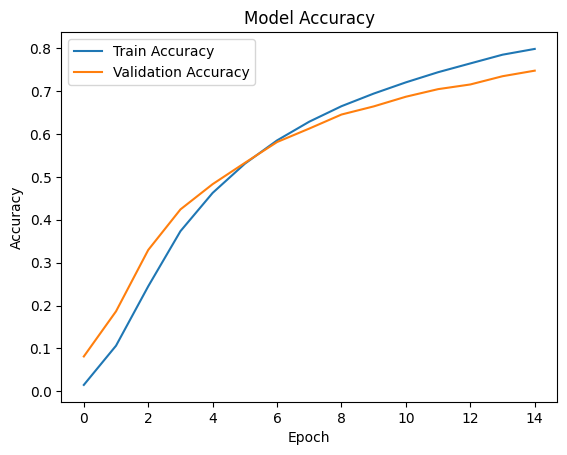

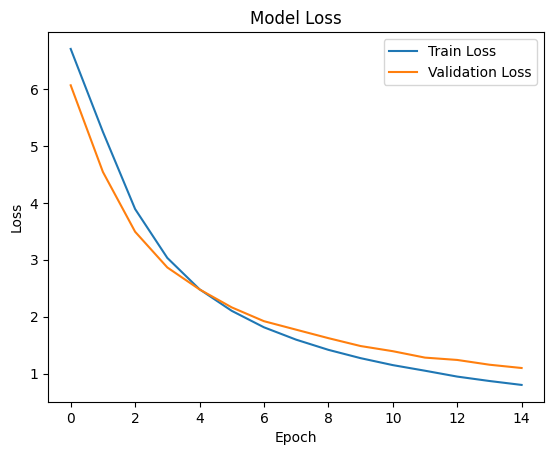

In [73]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [74]:
print("Training time:", training_time,"\nInference Time:", inference_time)

Training time: 95.23893117904663 
Inference Time: 8.33965516090393
